In [26]:
import pandas as pd
import os
import re
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora
from pprint import pprint
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models as pg

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
raw_data = pd.read_csv('reviews.csv')

**DATA PREPROCESSING**

In [17]:
df = raw_data.loc[:, raw_data.columns.intersection(['reviews.text'])]

In [18]:
df.head()

,reviews.text
0,This a fantastic white wine for any occasion!
1,"Tart, not sweet...very refreshing and delicious!"
2,I was given this wine so it was a delightful s...
3,This is a phenomenal wine and my new favorite ...
4,4 750ml bottles for the price of two With way ...


In [19]:
#remove punctutations
df['reviews_text_processed'] = df['reviews.text'].astype(str).map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the texts to lowercase
df['reviews_text_processed'] =df['reviews_text_processed'].astype(str).map(lambda x: x.lower())


<input>:2: DeprecationWarning: invalid escape sequence \.
<input>:2: DeprecationWarning: invalid escape sequence \.
<input>:2: DeprecationWarning: invalid escape sequence \.
<ipython-input-19-47f42bbe6220>:2: DeprecationWarning: invalid escape sequence \.
  df['reviews_text_processed'] = df['reviews.text'].astype(str).map(lambda x: re.sub('[,\.!?]', '', x))


In [20]:
df.head()

,reviews.text,reviews_text_processed
0,This a fantastic white wine for any occasion!,this a fantastic white wine for any occasion
1,"Tart, not sweet...very refreshing and delicious!",tart not sweetvery refreshing and delicious
2,I was given this wine so it was a delightful s...,i was given this wine so it was a delightful s...
3,This is a phenomenal wine and my new favorite ...,this is a phenomenal wine and my new favorite red
4,4 750ml bottles for the price of two With way ...,4 750ml bottles for the price of two with way ...


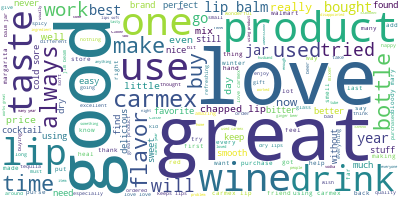

In [21]:
# Use the wordcloud library to get a visual representation of most common words.
# Join the different processed texts together.
long_string = ','.join(list(df['reviews_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [22]:
stop_words = stopwords.words('english')

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data = df.reviews_text_processed.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

['fantastic', 'white', 'wine', 'occasion']


In [23]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1)]


**LDA model training**

In [29]:
# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

[(0,
  '0.016*"like" + 0.015*"lips" + 0.012*"carmex" + 0.011*"product" + '
  '0.010*"love" + 0.010*"good" + 0.009*"using" + 0.009*"would" + 0.008*"lip" + '
  '0.008*"use"'),
 (1,
  '0.035*"lips" + 0.027*"carmex" + 0.016*"used" + 0.016*"product" + '
  '0.015*"works" + 0.010*"great" + 0.010*"good" + 0.010*"chapped" + '
  '0.009*"love" + 0.009*"one"'),
 (2,
  '0.047*"lips" + 0.024*"carmex" + 0.019*"product" + 0.017*"love" + '
  '0.015*"use" + 0.014*"chapped" + 0.012*"dry" + 0.011*"jar" + 0.009*"using" + '
  '0.009*"time"'),
 (3,
  '0.023*"carmex" + 0.018*"wine" + 0.017*"lips" + 0.012*"like" + 0.011*"love" '
  '+ 0.010*"great" + 0.009*"good" + 0.008*"years" + 0.007*"taste" + '
  '0.007*"one"'),
 (4,
  '0.018*"jar" + 0.017*"love" + 0.017*"product" + 0.015*"wine" + '
  '0.014*"carmex" + 0.011*"lips" + 0.010*"would" + 0.009*"lip" + 0.009*"used" '
  '+ 0.009*"use"'),
 (5,
  '0.016*"great" + 0.013*"carmex" + 0.012*"lips" + 0.008*"dry" + '
  '0.007*"product" + 0.006*"drink" + 0.006*"use" + 0.006

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [30]:
import os
#visualize the topics for interpretability
LDAvis_prepared = pg.prepare(lda_model, corpus, id2word)

In [31]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.072394  0.002080       1        1  14.664149
6     -0.054578  0.016163       2        1  13.730212
9     -0.033686  0.018914       3        1  12.124951
4      0.007852  0.059827       4        1  10.490966
5      0.072907 -0.065559       5        1   9.683232
7     -0.010801  0.005376       6        1   9.023220
0      0.027582 -0.039297       7        1   8.111358
1     -0.061055 -0.043274       8        1   7.997319
3      0.031621 -0.003995       9        1   7.202902
8      0.092554  0.049765      10        1   6.971690, topic_info=        Term         Freq        Total Category  logprob  loglift
47     great   494.000000   494.000000  Default  30.0000  30.0000
3       wine   380.000000   380.000000  Default  29.0000  29.0000
1240    lips  1153.000000  1153.000000  Default  28.0000  28.0000
4248  carmex  1082.000000  1082.000000  Default  27.0000  27.0000
2062     jar   412.000000   412.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
215    every    12.550351   180.848250  Topic10  -5.6224  -0.0046
298     time    13.733992   261.999067  Topic10  -5.5323  -0.2852
51       one    13.144674   335.670460  Topic10  -5.5762  -0.5768
782      use    13.048568   440.503786  Topic10  -5.5835  -0.8559
2062     jar    11.997350   412.492384  Topic10  -5.6675  -0.8742

[831 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
4536      8  0.816311  accidentally
5640      8  0.816312          ache
3148      1  0.700074            ad
3148      4  0.233358            ad
3148     10  0.233358            ad
...     ...       ...           ...
4195      4  0.803024        yeasty
4567      8  0.816312         youit
4760      3  0.759751       zippers
5641      8  0.816311         zippy
4904      1  0.860778       zustand

[2060 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 10, 5, 6, 8, 1, 2, 4, 9])